# `supernest` demonstration

In this interactive notebook we shall guid you through the typical process of using `supernest` for your Bayesian inference workflow. For simplicity we shall approximate cosmological inference, with a Gaussian approximation. This should demonstrate the efficacy of supernest on a realistic example, while sparing you the expense of HPC testing. 

The code, while not exactly the same as what is used inside the `cobaya`'s supernest integration, is representative of what the of the interface and the kinds of work that need to be done in order to incorporate it into your workflow.  

##  Dependencies

In this example we shall be using William Handley's excellent `polychord` package to explore a facsimile of a typical Lambda CDM inference done by a typical cosmological package like `cobaya`. 

In [9]:
!pip install supernest anesthetic mpi4py ipyparallel

Defaulting to user installation because normal site-packages is not writeable


**NOTE**: there is an issue with `pandas`, so you must reload the runtime after executing the above block.

Installing polychord is a tiny bit more involved. In real life you want to enable MPI support to make use of multiple CPU cores, but in this colab notebook, it is sufficient to install `polychord` the easy way.  

In [10]:
pip install https://github.com/PolyChord/PolyChordLite/archive/master.zip

Defaulting to user installation because normal site-packages is not writeable
  Using cached https://github.com/PolyChord/PolyChordLite/archive/master.zip
Note: you may need to restart the kernel to use updated packages.


## Setting up the prior

Bayesian inference is the process of turning two probability distributions representing your knowledge before a data set, into two other probability distributions, representing your knowledge after, including how confident you are in your underlying theory. 

The inputs are called the prior, and the likelihood. The likelihood is ususally specified via the logarithm of the probability density function. Normally the prior is convenient to represent via the point-percent function or quantile; it's a mapping that takes parameters from a uniform unit hypercube `[0, 1]` and maps them onto the real space of your parameters with the desired probability density. 

**Note**: a few nested samplers e.g. `multinest` do not allow  a separate prior and likelihood function, but instead use the unit hypercube as the space for calculating the probability distributions. `Polychord` provides the separation as a purely optional convenience.  

We shall start by defining the prior widths. These can be found in e.g. `cobaya`. This represents the minimum and maximum values a given parameter can obtain during inference.  

**NOTE**: In our case, all priors are uniform. This is done for technical reasons, but also inadvertently simplifies the repartitioning. `supernest` operates under the assumption that your priors are all uniform. If you have a non-uniform prior (and a sampler that can cope with `inf` and `nan`), you should refer to the paper (TODO) for how to properly repartition the prior and likelihood. 

The bounds are:

In [11]:
import numpy as np

bounds = np.array([[1.610000000000000098e+00, 3.910000000000000142e+00],
                  [8.000000000000000444e-01, 1.199999999999999956e+00],
                  [5.000000000000000000e-01, 1.000000000000000000e+01],
                  [5.000000000000000104e-03, 1.000000000000000056e-01],
                  [1.000000000000000021e-03, 9.899999999999999911e-01],
                  [1.000000000000000021e-02, 8.000000000000000444e-01],
                  [9.874342179098187788e-01, 1.012565782090074640e+00],
                  [9.966815810147492405e-01, 1.003718418985220850e+00],
                  [9.947828966565528397e-01, 1.001317103343419390e+00],
                  [0.000000000000000000e+00, 2.000000000000000000e+02],
                  [0.000000000000000000e+00, 1.000000000000000000e+00],
                  [0.000000000000000000e+00, 1.000000000000000000e+01],
                  [0.000000000000000000e+00, 1.000000000000000000e+01],
                  [-1.452625672144938207e+00, 1.865262567205973454e+01],
                  [5.473743278550617930e-01, 2.065262567205973454e+01],
                  [-1.922365910661598321e+01, 6.622365910625386221e+01],
                  [-8.626256721449379938e+00, 1.924262567205973369e+02],
                  [0.000000000000000000e+00, 4.000000000000000000e+02],
                  [0.000000000000000000e+00, 4.000000000000000000e+02],
                  [0.000000000000000000e+00, 4.000000000000000000e+02],
                  [0.000000000000000000e+00, 4.000000000000000000e+02],
                  [-8.110513911504371731e-02, 3.411051391132544075e-01],
                  [-5.094726209860886423e-02, 3.109472620970751833e-01],
                  [7.631844753477834420e-03, 9.123681552426879948e-01],
                  [-1.548945241972177478e-01, 5.688945241941503195e-01],
                  [2.376318447534777611e-01, 1.142368155242687866e+00],
                  [-7.762089314791336125e-01, 4.652208931456128127e+00]])


Now we want the covariance matrix, which is quite a bit more sizeable. 

In [12]:
covs = np.array([
                [2.968145029999999865e-02, 3.135427750000000131e-03, 8.338248970000000388e-04, -4.217618689999999727e-05, 2.650284049999999947e-03, 1.200952880000000092e-03, 5.068381450000000049e-05, 4.746630099999999926e-06, -1.581929089999999907e-06, 2.663628749999999989e-01, 8.828913119999999603e-05, -2.216902540000000206e-03, 8.404302719999999505e-03, 1.432890180000000126e-04, -7.558739230000000031e-03, 1.944324650000000057e-02, -5.093156110000000153e-02, -6.004830359999999700e-01, 8.669781009999999455e-01, 8.293443280000000195e-01, 2.503914819999999986e-01, 3.708188239999999866e-05, 7.674027270000000588e-05, 1.178210749999999941e-04, 1.037332909999999936e-04, 4.387946019999999802e-04, -2.495634950000000154e-03],
                [3.135427750000000131e-03, 3.185720349999999861e-03, 3.130486989999999871e-05, 9.000653609999999629e-05, 9.083279789999999972e-04, 7.353195660000000269e-04, 2.200058280000000188e-06, 2.044903099999999917e-06, -1.621079909999999999e-06, 1.719608519999999974e-01, 1.571867659999999977e-04, -1.503148840000000054e-03, 7.397394500000000449e-04, 8.864634000000000142e-04, 1.262831960000000133e-04, -3.087391200000000162e-03, -1.691096259999999921e-02, -3.842335519999999782e-01, 5.685709920000000528e-01, 5.616310949999999691e-01, 2.650536399999999793e-01, -1.543663889999999895e-05, -2.117700089999999846e-05, 5.166042389999999827e-05, -2.951145799999999869e-05, 9.090266650000000808e-06, -9.575564690000000012e-04],
                [8.338248970000000388e-04, 3.130486989999999871e-05, 1.816877529999999996e-03, -1.996604279999999933e-04, 2.384585130000000178e-03, -2.852508560000000098e-05, -1.521311770000000076e-07, 5.252263470000000354e-07, 2.437715000000000067e-07, -3.119262570000000054e-02, 7.871063490000000239e-05, -7.434610499999999653e-04, 7.893933009999999856e-04, 6.761066239999999946e-04, -2.290230030000000184e-03, -3.122185720000000028e-04, -1.494500340000000024e-02, -2.381864809999999829e-03, -4.836481229999999715e-02, -4.788839739999999762e-02, -3.567536159999999679e-02, -5.175818659999999991e-05, 2.748901660000000065e-05, 6.211406010000000439e-05, 5.386665410000000294e-05, 1.777272519999999835e-05, -7.698531549999999531e-05],
                [-4.217618689999999727e-05, 9.000653609999999629e-05, -1.996604279999999933e-04, 1.888281059999999986e-04, 1.106031419999999998e-03, 9.007079379999999866e-05, -2.207499039999999946e-06, 1.061611120000000028e-06, -5.089118919999999502e-07, 1.425302519999999962e-01, -4.923472619999999907e-05, -5.899677009999999616e-04, 2.296787319999999809e-03, -1.286683270000000059e-03, 3.491789569999999808e-04, 1.309846360000000050e-02, -1.277812250000000000e-03, -1.475363419999999870e-01, 4.067879440000000124e-01, 4.406117059999999919e-01, 2.457505739999999994e-01, 2.945679510000000020e-05, -1.120544580000000044e-05, -4.700972779999999823e-05, -2.730662089999999958e-05, 1.757231910000000140e-05, -5.257990180000000078e-04],
                [2.650284049999999947e-03, 9.083279789999999972e-04, 2.384585130000000178e-03, 1.106031419999999998e-03, 2.305775319999999948e-02, 8.833757960000000091e-04, -3.094293819999999862e-05, 1.471807969999999937e-05, -5.576546339999999849e-06, 1.724855170000000104e+00, -4.480229409999999949e-04, -9.954579220000000714e-03, 3.094260169999999907e-02, -9.166353650000000353e-03, -6.590823330000000410e-04, 1.871629740000000097e-01, -3.167506099999999741e-02, -1.829276710000000028e+00, 5.180736470000000260e+00, 5.422197459999999580e+00, 3.102142129999999831e+00, 1.465743919999999885e-04, -5.914557379999999730e-05, -5.425758050000000377e-04, -2.333443100000000020e-04, 4.939308170000000515e-04, -5.592697169999999961e-03],
                [1.200952880000000092e-03, 7.353195660000000269e-04, -2.852508560000000098e-05, 9.007079379999999866e-05, 8.833757960000000091e-04, 1.394232150000000075e-03, -5.430461349999999699e-06, 3.162541049999999833e-06, -1.407582420000000052e-06, 2.775386970000000009e-01, 2.874008540000000159e-05, -2.216153279999999968e-03, 7.333879679999999630e-03, -1.789817310000000033e-03, -1.586509480000000086e-03, 2.309489559999999830e-02, -3.918476910000000257e-02, -4.232265399999999844e-01, 9.278675269999999697e-01, 8.092088360000000424e-01, 3.764559630000000046e-01, 8.619862329999999602e-05, 3.497960350000000174e-06, -1.277038529999999868e-04, -8.261150620000000649e-05, 1.411206949999999917e-04, -9.305383449999999907e-04],
                [5.068381450000000049e-05, 2.200058280000000188e-06, -1.521311770000000076e-07, -2.207499039999999946e-06, -3.094293819999999862e-05, -5.430461349999999699e-06, 3.207137569999999878e-05, -9.275151899999999787e-08, 1.536967179999999926e-08, -2.676847170000000182e-03, -7.972937719999999965e-06, 9.967279499999999849e-05, -2.950069400000000056e-05, 1.163374879999999958e-04, -2.177143750000000021e-04, -8.539839430000000257e-04, 2.377882559999999930e-03, 1.017018630000000000e-02, -1.112197019999999932e-02, -1.169547909999999954e-02, 3.558528669999999963e-03, -5.210708710000000400e-06, -3.755179240000000141e-06, 1.589262890000000033e-06, -3.542850149999999793e-06, 6.292153939999999865e-06, 3.827967799999999857e-05],
                [4.746630099999999926e-06, 2.044903099999999917e-06, 5.252263470000000354e-07, 1.061611120000000028e-06, 1.471807969999999937e-05, 3.162541049999999833e-06, -9.275151899999999787e-08, 2.450719240000000013e-06, 2.947908970000000176e-10, 3.294882759999999845e-03, 1.548658669999999992e-07, 6.747006970000000623e-05, 6.256752239999999340e-05, 2.386572300000000047e-04, -4.233408830000000181e-04, 3.562502720000000102e-04, -5.452824429999999795e-04, 5.044431420000000318e-03, 1.121857610000000054e-02, 1.009086319999999946e-02, 5.628793669999999916e-03, 9.622558170000000086e-07, -5.816158569999999957e-07, -2.632452610000000035e-06, -1.420467419999999972e-06, 1.511541179999999934e-06, 3.408651769999999823e-06],
                [-1.581929089999999907e-06, -1.621079909999999999e-06, 2.437715000000000067e-07, -5.089118919999999502e-07, -5.576546339999999849e-06, -1.407582420000000052e-06, 1.536967179999999926e-08, 2.947908970000000176e-10, 2.150061509999999890e-06, 9.534150670000000492e-04, 6.349712240000000204e-08, -3.984490149999999770e-06, -5.037175890000000067e-05, -3.098377860000000255e-05, -3.934796110000000164e-05, 1.030094729999999964e-03, 3.422361860000000099e-03, 1.711678990000000062e-03, -4.159122559999999837e-03, -3.906880540000000172e-03, -5.618961530000000058e-03, -4.119654119999999825e-07, 2.450625880000000164e-07, -2.852389519999999887e-07, 5.749106310000000168e-07, -2.534326339999999862e-06, 4.315492620000000351e-06],
                [2.663628749999999989e-01, 1.719608519999999974e-01, -3.119262570000000054e-02, 1.425302519999999962e-01, 1.724855170000000104e+00, 2.775386970000000009e-01, -2.676847170000000182e-03, 3.294882759999999845e-03, 9.534150670000000492e-04, 1.440978980000000092e+03, -3.081545090000000209e-01, -2.641624010000000133e+00, 7.786807289999999604e+00, -1.606083160000000065e+00, 7.194975639999999784e-01, 1.978751240000000067e+01, -3.526100470000000087e+02, -3.425249029999999948e+02, 1.261326369999999997e+03, 1.154578680000000077e+03, -4.747657399999999583e+00, 1.036431869999999977e-01, -2.436002129999999960e-02, -2.104166219999999976e-01, -9.044435889999999367e-02, 1.450768600000000019e-01, -1.482414160000000036e+00],
                [8.828913119999999603e-05, 1.571867659999999977e-04, 7.871063490000000239e-05, -4.923472619999999907e-05, -4.480229409999999949e-04, 2.874008540000000159e-05, -7.972937719999999965e-06, 1.548658669999999992e-07, 6.349712240000000204e-08, -3.081545090000000209e-01, 8.267654939999999342e-02, -1.473520380000000081e-02, 4.926706389999999623e-03, -7.635348800000000408e-03, 6.532229120000000028e-03, 7.658044989999999996e-02, 8.133349769999999312e-02, -2.376457829999999855e-02, 2.719628419999999824e-01, 9.227935640000000106e-01, -4.086331979999999892e-02, 1.536488919999999899e-05, 8.388438459999999857e-05, -3.777001800000000183e-05, -9.301300049999999668e-05, -1.172250289999999959e-04, -6.434749160000000252e-04],
                [-2.216902540000000206e-03, -1.503148840000000054e-03, -7.434610499999999653e-04, -5.899677009999999616e-04, -9.954579220000000714e-03, -2.216153279999999968e-03, 9.967279499999999849e-05, 6.747006970000000623e-05, -3.984490149999999770e-06, -2.641624010000000133e+00, -1.473520380000000081e-02, 6.518264280000000355e+00, -1.387219179999999996e+00, -1.367270369999999957e-01, 1.194643209999999983e-01, 2.821549019999999963e+00, 3.298345030000000122e+00, -2.491816289999999867e+01, -1.223843970000000070e+01, 1.536538849999999901e+00, -1.645540309999999895e+00, -3.171848639999999943e-04, 5.844647169999999878e-04, 9.933778370000000569e-04, 1.001515060000000108e-03, 2.004961750000000022e-03, 5.215395280000000022e-03],
                [8.404302719999999505e-03, 7.397394500000000449e-04, 7.893933009999999856e-04, 2.296787319999999809e-03, 3.094260169999999907e-02, 7.333879679999999630e-03, -2.950069400000000056e-05, 6.256752239999999340e-05, -5.037175890000000067e-05, 7.786807289999999604e+00, 4.926706389999999623e-03, -1.387219179999999996e+00, 7.920213600000000298e+00, -2.901886500000000133e-02, -2.223419490000000109e-01, -3.436787889999999845e-01, -1.914725250000000045e+00, -8.574309899999999374e+00, 2.145733189999999979e+01, 1.362226629999999972e+01, 2.949081640000000171e+00, 4.618665850000000170e-03, -1.545935339999999960e-03, -3.823149850000000152e-03, -3.927817699999999919e-03, 4.683757769999999723e-03, -5.841703680000000232e-02],
                [1.432890180000000126e-04, 8.864634000000000142e-04, 6.761066239999999946e-04, -1.286683270000000059e-03, -9.166353650000000353e-03, -1.789817310000000033e-03, 1.163374879999999958e-04, 2.386572300000000047e-04, -3.098377860000000255e-05, -1.606083160000000065e+00, -7.635348800000000408e-03, -1.367270369999999957e-01, -2.901886500000000133e-02, 2.005499670000000023e+01, 9.960810639999999605e-01, 4.162989160000000188e-01, -5.134093060000000141e-04, -1.697497690000000148e+01, -6.585026489999999733e+00, -7.224663480000000249e+00, -5.136515300000000117e+00, -9.323316919999999472e-04, 1.522835690000000006e-03, 3.348195369999999813e-03, -2.129415349999999856e-03, 1.603642329999999941e-03, 2.918191380000000057e-02],
                [-7.558739230000000031e-03, 1.262831960000000133e-04, -2.290230030000000184e-03, 3.491789569999999808e-04, -6.590823330000000410e-04, -1.586509480000000086e-03, -2.177143750000000021e-04, -4.233408830000000181e-04, -3.934796110000000164e-05, 7.194975639999999784e-01, 6.532229120000000028e-03, 1.194643209999999983e-01, -2.223419490000000109e-01, 9.960810639999999605e-01, 1.984640130000000013e+01, 8.660322230000000232e+00, 6.153933099999999712e+00, 1.983209829999999840e+01, -9.564703279999999808e+00, -4.002715959999999740e+00, -2.969334379999999829e+00, -8.756303569999999460e-04, 1.029166989999999926e-03, -2.884666640000000185e-03, 5.468167860000000373e-03, 1.839993719999999996e-03, -3.636279600000000278e-02],
                [1.944324650000000057e-02, -3.087391200000000162e-03, -3.122185720000000028e-04, 1.309846360000000050e-02, 1.871629740000000097e-01, 2.309489559999999830e-02, -8.539839430000000257e-04, 3.562502720000000102e-04, 1.030094729999999964e-03, 1.978751240000000067e+01, 7.658044989999999996e-02, 2.821549019999999963e+00, -3.436787889999999845e-01, 4.162989160000000188e-01, 8.660322230000000232e+00, 2.356509039999999970e+02, 1.876819930000000056e+02, -2.703674859999999924e+01, 2.120874919999999975e+02, 3.629690579999999756e+01, 6.100736650000000338e+01, -1.107586719999999973e-03, 1.233026299999999929e-02, 1.622374920000000114e-04, -3.023772970000000032e-02, 5.477839019999999892e-03, 9.368195510000000559e-02],
                [-5.093156110000000153e-02, -1.691096259999999921e-02, -1.494500340000000024e-02, -1.277812250000000000e-03, -3.167506099999999741e-02, -3.918476910000000257e-02, 2.377882559999999930e-03, -5.452824429999999795e-04, 3.422361860000000099e-03, -3.526100470000000087e+02, 8.133349769999999312e-02, 3.298345030000000122e+00, -1.914725250000000045e+00, -5.134093060000000141e-04, 6.153933099999999712e+00, 1.876819930000000056e+02, 1.261320240000000013e+03, 5.039279619999999937e+01, -1.952933979999999892e+01, 8.179167650000000123e+00, 8.485509079999999926e+01, -2.312180470000000168e-02, 1.813267299999999846e-02, 1.114934820000000049e-01, -5.846903770000000042e-03, -6.729364679999999543e-02, 2.169466949999999950e-01],
                [-6.004830359999999700e-01, -3.842335519999999782e-01, -2.381864809999999829e-03, -1.475363419999999870e-01, -1.829276710000000028e+00, -4.232265399999999844e-01, 1.017018630000000000e-02, 5.044431420000000318e-03, 1.711678990000000062e-03, -3.425249029999999948e+02, -2.376457829999999855e-02, -2.491816289999999867e+01, -8.574309899999999374e+00, -1.697497690000000148e+01, 1.983209829999999840e+01, -2.703674859999999924e+01, 5.039279619999999937e+01, 7.114260500000000320e+03, -1.220674170000000004e+03, -1.326360359999999901e+03, -7.387565799999999854e+02, -1.964240640000000093e-01, 2.247111590000000145e-02, 3.523370040000000092e-01, 2.047268070000000106e-01, -1.797178959999999881e-01, 1.291366699999999978e+00],
                [8.669781009999999455e-01, 5.685709920000000528e-01, -4.836481229999999715e-02, 4.067879440000000124e-01, 5.180736470000000260e+00, 9.278675269999999697e-01, -1.112197019999999932e-02, 1.121857610000000054e-02, -4.159122559999999837e-03, 1.261326369999999997e+03, 2.719628419999999824e-01, -1.223843970000000070e+01, 2.145733189999999979e+01, -6.585026489999999733e+00, -9.564703279999999808e+00, 2.120874919999999975e+02, -1.952933979999999892e+01, -1.220674170000000004e+03, 7.373464640000000145e+03, 4.101727829999999813e+03, 1.954825180000000046e+03, 3.747203239999999935e-01, -5.835444840000000161e-02, -3.372460529999999901e-01, -2.188041410000000075e-01, 4.807094419999999868e-01, -4.262176539999999569e+00],
                [8.293443280000000195e-01, 5.616310949999999691e-01, -4.788839739999999762e-02, 4.406117059999999919e-01, 5.422197459999999580e+00, 8.092088360000000424e-01, -1.169547909999999954e-02, 1.009086319999999946e-02, -3.906880540000000172e-03, 1.154578680000000077e+03, 9.227935640000000106e-01, 1.536538849999999901e+00, 1.362226629999999972e+01, -7.224663480000000249e+00, -4.002715959999999740e+00, 3.629690579999999756e+01, 8.179167650000000123e+00, -1.326360359999999901e+03, 4.101727829999999813e+03, 6.486187549999999646e+03, 2.350870899999999892e+03, 3.387937970000000076e-01, -8.457468129999999584e-02, -3.820059860000000196e-01, -2.596811239999999854e-01, 4.515744870000000244e-01, -4.136748350000000407e+00],
                [2.503914819999999986e-01, 2.650536399999999793e-01, -3.567536159999999679e-02, 2.457505739999999994e-01, 3.102142129999999831e+00, 3.764559630000000046e-01, 3.558528669999999963e-03, 5.628793669999999916e-03, -5.618961530000000058e-03, -4.747657399999999583e+00, -4.086331979999999892e-02, -1.645540309999999895e+00, 2.949081640000000171e+00, -5.136515300000000117e+00, -2.969334379999999829e+00, 6.100736650000000338e+01, 8.485509079999999926e+01, -7.387565799999999854e+02, 1.954825180000000046e+03, 2.350870899999999892e+03, 4.760221349999999802e+03, 1.429834060000000073e-01, -5.065991630000000329e-02, -2.989657660000000217e-01, -1.799586410000000025e-01, 2.845544890000000215e-01, -1.751175160000000064e+00],
                [3.708188239999999866e-05, -1.543663889999999895e-05, -5.175818659999999991e-05, 2.945679510000000020e-05, 1.465743919999999885e-04, 8.619862329999999602e-05, -5.210708710000000400e-06, 9.622558170000000086e-07, -4.119654119999999825e-07, 1.036431869999999977e-01, 1.536488919999999899e-05, -3.171848639999999943e-04, 4.618665850000000170e-03, -9.323316919999999472e-04, -8.756303569999999460e-04, -1.107586719999999973e-03, -2.312180470000000168e-02, -1.964240640000000093e-01, 3.747203239999999935e-01, 3.387937970000000076e-01, 1.429834060000000073e-01, 8.777600820000000179e-03, 4.811679979999999792e-04, 1.819639440000000083e-05, -9.129752990000000040e-04, -1.456107410000000038e-04, -4.306397559999999825e-04],
                [7.674027270000000588e-05, -2.117700089999999846e-05, 2.748901660000000065e-05, -1.120544580000000044e-05, -5.914557379999999730e-05, 3.497960350000000174e-06, -3.755179240000000141e-06, -5.816158569999999957e-07, 2.450625880000000164e-07, -2.436002129999999960e-02, 8.388438459999999857e-05, 5.844647169999999878e-04, -1.545935339999999960e-03, 1.522835690000000006e-03, 1.029166989999999926e-03, 1.233026299999999929e-02, 1.813267299999999846e-02, 2.247111590000000145e-02, -5.835444840000000161e-02, -8.457468129999999584e-02, -5.065991630000000329e-02, 4.811679979999999792e-04, 6.183778840000000131e-03, 1.722407989999999965e-04, 1.590148129999999910e-03, -9.959694779999999649e-05, -1.650932680000000022e-03],
                [1.178210749999999941e-04, 5.166042389999999827e-05, 6.211406010000000439e-05, -4.700972779999999823e-05, -5.425758050000000377e-04, -1.277038529999999868e-04, 1.589262890000000033e-06, -2.632452610000000035e-06, -2.852389519999999887e-07, -2.104166219999999976e-01, -3.777001800000000183e-05, 9.933778370000000569e-04, -3.823149850000000152e-03, 3.348195369999999813e-03, -2.884666640000000185e-03, 1.622374920000000114e-04, 1.114934820000000049e-01, 3.523370040000000092e-01, -3.372460529999999901e-01, -3.820059860000000196e-01, -2.989657660000000217e-01, 1.819639440000000083e-05, 1.722407989999999965e-04, 4.114830430000000067e-02, -4.079278590000000228e-04, 9.112142369999999547e-04, 9.620691069999999512e-03],
                [1.037332909999999936e-04, -2.951145799999999869e-05, 5.386665410000000294e-05, -2.730662089999999958e-05, -2.333443100000000020e-04, -8.261150620000000649e-05, -3.542850149999999793e-06, -1.420467419999999972e-06, 5.749106310000000168e-07, -9.044435889999999367e-02, -9.301300049999999668e-05, 1.001515060000000108e-03, -3.927817699999999919e-03, -2.129415349999999856e-03, 5.468167860000000373e-03, -3.023772970000000032e-02, -5.846903770000000042e-03, 2.047268070000000106e-01, -2.188041410000000075e-01, -2.596811239999999854e-01, -1.799586410000000025e-01, -9.129752990000000040e-04, 1.590148129999999910e-03, -4.079278590000000228e-04, 2.398725510000000033e-02, 8.721798849999999863e-04, -3.614700209999999799e-03],
                [4.387946019999999802e-04, 9.090266650000000808e-06, 1.777272519999999835e-05, 1.757231910000000140e-05, 4.939308170000000515e-04, 1.411206949999999917e-04, 6.292153939999999865e-06, 1.511541179999999934e-06, -2.534326339999999862e-06, 1.450768600000000019e-01, -1.172250289999999959e-04, 2.004961750000000022e-03, 4.683757769999999723e-03, 1.603642329999999941e-03, 1.839993719999999996e-03, 5.477839019999999892e-03, -6.729364679999999543e-02, -1.797178959999999881e-01, 4.807094419999999868e-01, 4.515744870000000244e-01, 2.845544890000000215e-01, -1.456107410000000038e-04, -9.959694779999999649e-05, 9.112142369999999547e-04, 8.721798849999999863e-04, 4.031588369999999921e-02, 1.806673790000000099e-02],
                [-2.495634950000000154e-03, -9.575564690000000012e-04, -7.698531549999999531e-05, -5.257990180000000078e-04, -5.592697169999999961e-03, -9.305383449999999907e-04, 3.827967799999999857e-05, 3.408651769999999823e-06, 4.315492620000000351e-06, -1.482414160000000036e+00, -6.434749160000000252e-04, 5.215395280000000022e-03, -5.841703680000000232e-02, 2.918191380000000057e-02, -3.636279600000000278e-02, 9.368195510000000559e-02, 2.169466949999999950e-01, 1.291366699999999978e+00, -4.262176539999999569e+00, -4.136748350000000407e+00, -1.751175160000000064e+00, -4.306397559999999825e-04, -1.650932680000000022e-03, 9.620691069999999512e-03, -3.614700209999999799e-03, 1.806673790000000099e-02, 1.155789100000000014e+00]])


Finally, we want the means of the distribution. 

In [13]:
means = [3.044288950736070198e+00,
        9.653584708627392930e-01,
        1.040891454387792958e+00,
        2.236941853859109389e-02,
        1.199402663897136123e-01,
        5.437839444140014217e-02,
        1.000558470278606116e+00,
        9.996645570914636236e-01,
        9.981974030346568716e-01,
        4.666402808735772823e+01,
        5.270013177546990502e-01,
        5.454231565893462808e+00,
        3.335504420623564670e+00,
        8.932986941158542749e+00,
        1.088025735501460289e+01,
        1.859118982188342528e+01,
        9.378313784298576650e+01,
        2.586977679317792536e+02,
        4.562007887290639019e+01,
        4.214808456289339489e+01,
        1.150478836453472695e+02,
        1.140812364024545444e-01,
        1.347717854911197333e-01,
        4.820886388532216182e-01,
        2.249421206923959693e-01,
        6.660807358891674967e-01, 
        2.084251798946145318e+00]


In [20]:
import os
import ipyparallel as ipp
# The difficulty with which this is achieved make me think that I in Ipython stands for Idiotic
rc = ipp.Client(profile="mpi")

rc[:]

NoEnginesRegistered: Can't build targets without any engines

# Testing Polychord without supernest

We set up a control to see how supernest compares, this 

We use a function to generate the prior and the likelihood. This is more convenient, because we can parameterise the creation, if we wanted a different multivariate Gaussian model. 

In [6]:
def generate_model(bounds, means, covs):
    thetamin, thetamax = bounds[:,0], bounds[:,1]
    invCov = np.linalg.inv(covs)

    def prior(cube):
        return thetamin + cube * (thetamax - thetamin)

    def log_likelihood(theta):
        return (-(theta - means) @ invCov @ (theta - means) / 2.0 , [])

    return prior, log_likelihood


At this point we have a complete set for the problem. The next step is to set up PolyChord itself.

In [7]:
import pypolychord
from mpi4py import MPI

from pypolychord.settings import PolyChordSettings # Note to WJH, adding PolyChordSettings to pypolychord might make it more readable. 

settings = PolyChordSettings(len(means), 0) # We haven't created any derived parameters and don't intend to
settings.file_root = 'control'
settings.nlive = 60
settings.num_repeats = 128
settings.do_clustering = True
settings.read_resume = False # Shouldn't be there
settings.write_resume = False # Wastes space.

control_pr, control_ll = generate_model(bounds, means, covs)

**SANITY CHECK**: the prior should map the 0-corner of the hypercube onto the minima.

In [8]:
np.allclose(control_pr(np.zeros(len(means))),bounds[:,0]) and np.allclose(control_pr(np.zeros(len(means)) + 1 ), bounds[:, 1])

True

And now run. 

**note**: This will take a minute and all output is suppressed. 

In [9]:
output = {"control": pypolychord.run_polychord(control_ll, len(means), 0, settings, prior=control_pr)}

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.18.2
  release: 7th April 2020
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :      60
nDims    :      27
nDerived :       0
Doing Clustering
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors

generating live points


all live points generated

Speed  1 =  0.355E-04 seconds
number of repeats:          128
started sampling

_________________
lives      |  60 |
phantoms   |5122 |
posteriors |  61 |
equals     |   1 |
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
ncluster   =       1 /       1
ndead      =                  61
nposterior =                  61
nequals    =                   1
nlike      =                9368
<nlike>    =         155.13   (           1.21 per slice )
log(Z)     =        -6548.12 +/-  0.83
log(Z_1)   =        -6548.12 +/-  0.83 (still evaluating)


_________________
lives      |  60 |
phantoms   |8094 |
posteriors |1159 |
equals     | 316 |
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
ncluster   =       1 /       1
ndead      =                1159
nposterior =                1159
nequals    =                 326
nlike      =              375067
<nlike>    =         485.27   (           3.79 per slice )
log(Z)     =          -27.42 +/-  0.47
log(Z_1)   =          -27.42 +/-  0.47 (still evaluating)



_________________
lives      |  60 |
phantoms   |7790 |
posteriors |1220 |
equals     | 356 |
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
ncluster   =       1 /       1
ndead      =                1220
nposterior =                1220
nequals    =                 363
nlike      =              405187
<nlike>    =         502.00   (           3.92 per slice )
log(Z)     =          -27.31 +/-  0.48
log(Z_1)   =          -27.31 +/-  0.48 (still evaluating)



_________________
lives      |  60 |
phantoms   |7666 |
posteriors |1281 |
equals     | 380 |
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
ncluster   =       1

## Plotting the results

Here we're trying to make sure that the plot makes sense. First, for clarity, let's create named parameters

In [10]:
paramnames = [(f'theta{i}', r'\theta_{}'.format(i)) for i in range(len(means))]
output["control"].make_paramnames_files(paramnames)

Use anesthetic to plot the results. We specify the types so that the plots don't take up too much space. 

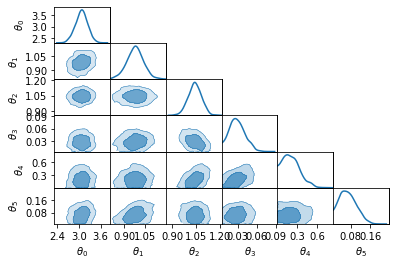

In [11]:
from anesthetic import NestedSamples
from os.path import join
%matplotlib inline
import matplotlib.pyplot as plt


samples = {"control": NestedSamples(root = join(settings.base_dir, settings.file_root))}
fig, axes = samples["control"].plot_2d(['theta0', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5'], types={'lower': 'kde', 'diagonal': 'kde'})

plt.show()

## The evidence 

Bayes' theorem reads as $$ \pi (\theta) {\cal L} (\theta) = {\cal Z}  {\cal P} (\theta),$$ where ${\cal Z}$ is the evidence, a scalar in our case. Because both the prior $\pi$ and ${\cal L}$ the likelihood are probability distributions, one of which is a mere uniform probability distribution, the other a multivariate Gaussian, we can derive the evidence analytically. $${\cal Z} = \int \pi ( \theta) {\cal L} (\theta)\, d\theta $$

Here $\pi (\theta)$ is a constant, that's equal to $$\prod_i (\theta_{max} - \theta_{min})_i $$ The ${\cal L}(\theta)$, is a correlated multivariate non-normalised Gaussian, which we evaluate to:
$$ \int d\theta \exp \left[ - (\theta - \mu)^{T} \Sigma^{-1} \frac{(\theta - \mu) }{2}\right] = \sqrt{\det (2 \pi \Sigma)}$$

In [12]:
logZ_expected = len(means)*np.log(2*np.pi)/2 + np.linalg.slogdet(covs)[1]/2 - np.sum(np.log(bounds[:, 1] - bounds[:,0])); logZ_expected

-25.781804666999363

analytically, we on the other hand find:

In [13]:
(output["control"].logZ, output["control"].logZerr)

(-27.0649041685565, 0.49063070480001)

As we can see, nested sampling isn't perfect. We haven't found the full evidence. Moreover, the internal estimate of the error is insufficient:

In [14]:
(logZ_expected - output["control"].logZ) / output["control"].logZerr

2.6152042442597434

This doesn't wholly invalidate nested sampling, just means that you shouldn't **blindly** trust what the nested sampler tells you. If we look at the first 1000 estimates, we can see why. 

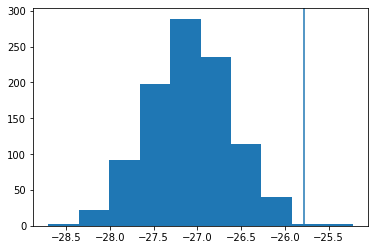

In [15]:
plt.hist(samples["control"].logZ(1000)); plt.axvline(logZ_expected);plt.show()

**NOTE**: If we increased the number of live points, we might be able to suppress one of the source of error. We would *hope* that it would bring the average closer to the true value, but it might just reduce the error estimate, without moving the means closer together in any way. 

# Testing polychord with `supernest`.

Supernest works by providing alternative (re-partitioned) views of the same problem. One such view is the so-called **proposal**. It's a multivariate Gaussian prior with an adjusted likelihood. 

## The proposal

In [16]:
import supernest as sn

In [17]:
proposal  = sn.gaussian_proposal(bounds.T, means, covs, loglike=control_ll); proposal
settings.file_root="proposal"

**NOTE**: the resultant proposal is an unbounded prior point-percent function. Meaning that the corners of the hypercube map to infinities. We cannot allow for that to happen, and so we move all `inf` and `nan` values to an agreed upon $\log 0$, and $-\log 0$ for plus and minus infinity. 

In [18]:
proposal.prior(np.zeros(len(means)))

/mnt/Archive/Git/sspr/supernest/core.py:180: RuntimeWarning: invalid value encountered in matmul
  theta = mean + covmat @ theta


array([-1.e+30, -1.e+30, -1.e+30, -1.e+30, -1.e+30, -1.e+30, -1.e+30,
       -1.e+30, -1.e+30, -1.e+30, -1.e+30, -1.e+30, -1.e+30, -1.e+30,
       -1.e+30, -1.e+30, -1.e+30, -1.e+30, -1.e+30, -1.e+30, -1.e+30,
       -1.e+30, -1.e+30, -1.e+30, -1.e+30, -1.e+30, -1.e+30])

As you can see, this is a named tuple, whose members can be used directly in place of `control_ll` and `control_pr`. 

**note**: this might take a minute. Be patient!

In [19]:
output["proposal"] = pypolychord.run_polychord(proposal.likelihood, len(means), 0, settings, prior=proposal.prior)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.18.2
  release: 7th April 2020
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :      60
nDims    :      27
nDerived :       0
Doing Clustering
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors

generating live points


all live points generated

Speed  1 =  0.146E-03 seconds
number of repeats:          128
started sampling

_________________
lives      |  60 |
phantoms   |5577 |
posteriors |  61 |
equals     |  31 |
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
ncluster   =       1 /       1
ndead      =                  61
nposterior =                  61
nequals    =                  39
nlike      =               17367
<nlike>    =         288.45   (           2.25 per slice )
log(Z)     =          -26.24 +/-  0.07
log(Z_1)   =          -26.24 +/-  0.07 (still evaluating)


We can now check the evidence

In [20]:
(logZ_expected - output["proposal"].logZ) / output["proposal"].logZerr

1.3778494969146027

Much better! Not only did we get closer to the expected theoretical result, but we did so faster:

In [21]:
(output["control"].ndead - output["proposal"].ndead)/output["proposal"].ndead

2.8819875776397517

and on top of all that, we got better precision:

In [22]:
(output["control"].logZerr - output["proposal"].logZerr) / output["proposal"].logZerr

19466.178345426037

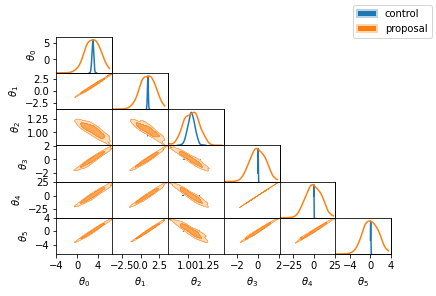

In [23]:
paramnames = [(f'theta{i}', r'\theta_{}'.format(i)) for i in range(len(means))]
output["proposal"].make_paramnames_files(paramnames)
samples["proposal"] = NestedSamples(root = join(settings.base_dir, settings.file_root))
fig, axes = samples["control"].plot_2d(['theta0', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5'], types={'lower': 'kde', 'diagonal': 'kde'}, label="control")
samples["proposal"].plot_2d(axes, label="proposal")
handles, labels = axes["theta0"]["theta1"].get_legend_handles_labels()
fig.legend(handles, labels)
plt.show()

## TODO: Truncated Gaussian proposals



In theory, the proposal that we've just created contains the exact shape of the posterior distribution. But it also includes areas of the original model that would have been rejected at the prior level. We could sacrifice some information by using the diagonal elements of the covariance matrix, and instead use the truncated normal distribution: 

In [24]:
t_proposal  = sn.truncated_gaussian_proposal(bounds.T, means, covs, loglike=control_ll)
settings.file_root="t_proposal"

This prior never produces values outside the original prior. 

In [25]:
t_proposal.prior(np.zeros(len(means)))

array([ 1.61000000e+00,  8.00000000e-01,  5.00000000e-01,  5.00000000e-03,
        1.00000000e-03,  1.00000000e-02,  9.87434218e-01,  9.96681581e-01,
        9.94782897e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.45262567e+00,  5.47374328e-01, -1.92236591e+01,
       -8.62625672e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -8.11051391e-02, -5.09472621e-02,  7.63184475e-03,
       -1.54894524e-01,  2.37631845e-01, -7.76208931e-01])

In [26]:
output["t_proposal"] = pypolychord.run_polychord(t_proposal.likelihood, len(means), 0, settings, prior=t_proposal.prior)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.18.2
  release: 7th April 2020
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :      60
nDims    :      27
nDerived :       0
Doing Clustering
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors

generating live points


all live points generated

Speed  1 =  0.219E-03 seconds
number of repeats:          128
started sampling

_________________
lives      |  60 |
phantoms   |5201 |
posteriors |  61 |
equals     |  24 |
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
ncluster   =       1 /       1
ndead      =                  61
nposterior =                  61
nequals    =                  24
nlike      =                9569
<nlike>    =         158.48   (           1.24 per slice )
log(Z)     =          -66.61 +/-  0.15
log(Z_1)   =          -66.61 +/-  0.15 (still evaluating)


In [27]:
paramnames = [(f'theta{i}', r'\theta_{}'.format(i)) for i in range(len(means))]
output["t_proposal"].make_paramnames_files(paramnames)

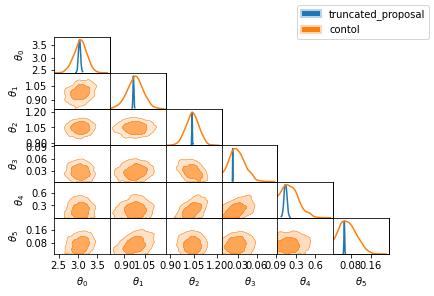

In [28]:
samples["t_proposal"] = NestedSamples(root = join(settings.base_dir, settings.file_root))
fig, axes = samples["t_proposal"].plot_2d(["theta0", "theta1", "theta2", "theta3", "theta4", "theta5"], types={'lower': 'kde', 'diagonal': 'kde'}, label="truncated_proposal")
samples["control"].plot_2d(axes, types={'lower': 'kde', 'diagonal': 'kde'}, label="contol")
handles, labels = axes["theta0"]["theta1"].get_legend_handles_labels()
fig.legend(handles, labels)

plt.show()

## Non-truncated diagonal proposal

Here we try to use an untruncated Gaussian proposal. This goes catastropohically bad. 

In [ ]:
settings.do_clustering = False
u_proposal = sn.gaussian_proposal(bounds.T, means, np.diag(np.diag(covs)), loglike=control_ll); settings.file_root = "u_proposal"
output["u_proposal"] = pypolychord.run_polychord(u_proposal.likelihood, len(means), 0, settings, prior=u_proposal.prior)

In [ ]:
output["u_proposal"].logZ 

So bad that it refuses to plot.

In [ ]:
paramnames = [(f'theta{i}', r'\theta_{}'.format(i)) for i in range(len(means))]
output["u_proposal"].make_paramnames_files(paramnames)
samples["u_proposal"] = NestedSamples(root = join(settings.base_dir, settings.file_root))

fig, axes = samples["u_proposal"].plot_2d(["theta0", "theta1", "theta2", "theta3", "theta4", "theta5"], types={'lower': 'kde', 'diagonal': 'kde'}, label="uncorrelated proposal")
samples["control"].plot_2d(axes, types={'lower': 'kde', 'diagonal': 'kde'}, label="contol")
handles, labels = axes["theta0"]["theta1"].get_legend_handles_labels()

fig.legend(handles, labels)

plt.show()


The error is telling. `ValueError: Contour levels must be increasing`. This is problematic for a few reasons. 

## TODO: What's the catch or why aren't we using proposals directly

What we fed into nested sampling was effectively the best case input that corresponds to the same model. You usually don't have a proposal that sits right on top of your posterior ${\cal P}$. We effectively told nested sampling what the answer was.

Suppose now, that the we didn't give it as much information: we gave it both slightly wrong means, and a slightly wrong covariance matrix. 

In [29]:
f_means = means + np.sqrt(np.diag(1.2*covs))
f_covs = covs*1.2
f_means

array([3.23301558e+00, 1.02718779e+00, 1.08758463e+00, 3.74224490e-02,
       2.86281193e-01, 9.52816777e-02, 1.00676215e+00, 1.00137945e+00,
       9.99803664e-01, 8.82473754e+01, 8.41980459e-01, 8.25100062e+00,
       6.41840181e+00, 1.38386975e+01, 1.57603887e+01, 3.54072858e+01,
       1.32687948e+02, 3.51094265e+02, 1.39684725e+02, 1.30371806e+02,
       1.90627415e+02, 2.16712231e-01, 2.20914310e-01, 7.04300171e-01,
       3.94602682e-01, 8.86033141e-01, 3.26193891e+00])

This is not a lot by any stretch of the meaning, and shouldn't cause any issues.

In [32]:
ft_proposal  = sn.truncated_gaussian_proposal(bounds.T, f_means, f_covs, loglike=control_ll)
settings.file_root="ft_proposal"
output["ft_proposal"] = pypolychord.run_polychord(ft_proposal.likelihood, len(means), 0, settings, prior=ft_proposal.prior)

In [34]:
output["ft_proposal"].logZ

-63.5793512344404

The truncated false proposal seems to be fine. It finds the right posterior peaks, finds them too narrow, and as a result finds only a small part of the evidence. 

However using the same with a false un-truncated proposal isn't fine. 

**Note** for some reason it is fine in this instance.

In [ ]:
f_proposal = sn.gaussian_proposal(bounds.T, f_means, f_covs, loglike=control_ll)
settings.file_root="f_proposal"
output["f_proposal"] = pypolychord.run_polychord(f_proposal.likelihood, len(means), 0, settings, prior=f_proposal.prior)

In [ ]:
output["f_proposal"].logZ

**THIS IS A BIG PROBLEM**

We only disturbed the proposal by a little bit, what we got was 

1. Not even within ballpark of the right evidence. 
2. Took significantly longer
3. Caused a few `inf`s and `nan`s to be generated. 


What if we wanted to confirm a result, but instead got a $5 \sigma$ discovery?

In [ ]:
mf_means = means + np.diag(5*covs); mf_covs = 1.2*covs
mf_proposal = sn.truncated_gaussian_proposal(bounds.T, mf_means, mf_covs, loglike=control_ll)
settings.file_root = "mft_proposal"
output["mft_proposal"] = pypolychord.run_polychord(mf_proposal.likelihood, len(means), 0, settings, prior=mf_proposal.prior)

In [ ]:
mf_means = means + np.diag(5*covs); mf_covs = 1.2*covs
mf_proposal = sn.gaussian_proposal(bounds.T, mf_means, mf_covs, loglike=control_ll)
settings.file_root = "mf_proposal"
output["mf_proposal"] = pypolychord.run_polychord(mf_proposal.likelihood, len(means), 0, settings, prior=mf_proposal.prior)

In [ ]:
(output["mf_proposal"].logZ  - logZ_expected) / output["mf_proposal"].logZerr

## Stochastic Superpositional Isometric (model) Mixtures

There is, however, a method of putting the uniform prior and the proposal on equal footing within the same sampling run, that uses the proposal only where it can speed things up, but falls back to the uniform prior where it makes sense to do so. This step is the Stochastic Superposition-al Isometric (model) Mixture SSIM, and the namesake of `supernest`.